# Corporación Favorita Grocery Sales Forecasting

### Time-Series Models

This notebook explores different models to forecast sales:
* Timetk
* ARIMA
* Prophet

In [13]:
# load library
library(data.table)
library(dplyr)
library(lubridate)
library(zoo)
library(ggplot2)
library(repr)
library(grid) # for multiplot
library(scales) # for date plotting
library(timetk)     # Toolkit for working with time series in R
library(quantmod)
library(tidyquant)
library(treemapify)
library(sweep)
library(forecast)
library(fpp2)
library(prophet);

Warning message:
"package 'prophet' was built under R version 3.4.3"Loading required package: Rcpp


In [14]:
# load datasets
#train <- readRDS(paste0(getwd(), '/data/train.rds'))
transactions <- readRDS(paste0(getwd(),'/data/transactions.rds'))


### Timeseries forecast of transaction data using timetk package

In [15]:
transData <- transactions %>%
 select(date, transactions) %>%
 group_by(date) %>%
 summarize(total = sum(transactions))

Check the indexed dates

In [16]:
idx <- tk_index(transData)
head(idx)

[1] "2013-01-01" "2013-01-02" "2013-01-03" "2013-01-04" "2013-01-05"
[6] "2013-01-06"

Get a "summary" of the timeseries differences in seconds. The timeseries differences give the user a better picture of the index frequency so the user can understand the level of regularity or irregulairity. 

In [17]:
tk_get_timeseries_summary(idx)

n.obs,start,end,units,scale,tzone,diff.minimum,diff.q1,diff.median,diff.mean,diff.q3,diff.maximum
1682,2013-01-01,2017-08-15,days,day,UTC,86400,86400,86400,86708.39,86400,172800


Check the time series signature from the index, a tibble of decomposed features

In [18]:
summary(tk_get_timeseries_signature(idx))

     index              index.num              diff             year     
 Min.   :2013-01-01   Min.   :1.357e+09   Min.   : 86400   Min.   :2013  
 1st Qu.:2014-02-26   1st Qu.:1.393e+09   1st Qu.: 86400   1st Qu.:2014  
 Median :2015-04-23   Median :1.430e+09   Median : 86400   Median :2015  
 Mean   :2015-04-24   Mean   :1.430e+09   Mean   : 86708   Mean   :2015  
 3rd Qu.:2016-06-19   3rd Qu.:1.466e+09   3rd Qu.: 86400   3rd Qu.:2016  
 Max.   :2017-08-15   Max.   :1.503e+09   Max.   :172800   Max.   :2017  
                                          NA's   :1                      
    year.iso         half          quarter          month       
 Min.   :2013   Min.   :1.000   Min.   :1.000   Min.   : 1.000  
 1st Qu.:2014   1st Qu.:1.000   1st Qu.:1.000   1st Qu.: 3.000  
 Median :2015   Median :1.000   Median :2.000   Median : 6.000  
 Mean   :2015   Mean   :1.463   Mean   :2.412   Mean   : 6.214  
 3rd Qu.:2016   3rd Qu.:2.000   3rd Qu.:3.000   3rd Qu.: 9.000  
 Max.   :2017   Ma

Add the time series signature features including numeric value, differences, year, month, day, day of week, day of month, day of year, hour, minute, second to the input data.

In [19]:
transData <- transData %>%
  tk_augment_timeseries_signature() %>%
  select(-(hour:am.pm), -diff) 

glimpse(transData)

Observations: 1,682
Variables: 24
$ date      <date> 2013-01-01, 2013-01-02, 2013-01-03, 2013-01-04, 2013-01-...
$ total     <dbl> 770, 93215, 78504, 78494, 93573, 90464, 75597, 72325, 719...
$ index.num <int> 1356998400, 1357084800, 1357171200, 1357257600, 135734400...
$ year      <int> 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 201...
$ year.iso  <int> 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 201...
$ half      <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ quarter   <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ month     <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ month.xts <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
$ month.lbl <ord> January, January, January, January, January, January, Jan...
$ day       <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...
$ wday      <int> 3, 4, 5, 6, 7, 1, 2, 3, 4, 5, 6, 7, 1, 2, 3, 4, 5, 6, 7, ...
$ wday.xts  <int> 

Separate into training and testing set

In [20]:
train <- transData %>%
  filter(date < '2017-01-01')

test <- transData %>%
  filter(date >= '2017-01-01')


Use basic linear regression model

In [21]:
fit_lm <- lm(total ~ ., data = select(train, -c(date)))
summary(fit_lm)


Call:
lm(formula = total ~ ., data = select(train, -c(date)))

Residuals:
   Min     1Q Median     3Q    Max 
-72774  -2695   -367   2251  74829 

Coefficients: (8 not defined because of singularities)
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -1.603e+09  8.568e+08  -1.871  0.06150 .  
index.num    -2.572e-02  1.378e-02  -1.865  0.06232 .  
year          7.100e+05  4.902e+05   1.448  0.14774    
year.iso      1.038e+05  7.038e+04   1.475  0.14038    
half         -5.196e+03  4.775e+03  -1.088  0.27667    
quarter       4.555e+04  1.583e+05   0.288  0.77357    
month         4.918e+04  6.254e+04   0.786  0.43176    
month.xts            NA         NA      NA       NA    
month.lbl.L          NA         NA      NA       NA    
month.lbl.Q   1.118e+04  1.947e+03   5.744 1.13e-08 ***
month.lbl.C   8.202e+03  3.997e+03   2.052  0.04036 *  
month.lbl^4   5.235e+03  9.332e+02   5.610 2.43e-08 ***
month.lbl^5   8.802e+03  3.157e+03   2.788  0.00538 ** 
month.lbl^6  

Make predictions

In [22]:
pred <- predict(fit_lm, newdata = select(test, -c(date)))

predictions <- data.frame( date = test$date, predictions = pred, actuals = test$total) %>%
  filter(date > '2017-01-01')
head(predictions)



Warning message in predict.lm(fit_lm, newdata = select(test, -c(date))):
"prediction from a rank-deficient fit may be misleading"

date,predictions,actuals
2017-01-02,80099.25,107718
2017-01-03,78135.95,97185
2017-01-04,79442.90,91527
2017-01-05,76066.76,84930
2017-01-06,81315.82,89963
2017-01-07,96847.20,102954


Plot the forecast.  The forecast is not very good and fails to capture peaks.

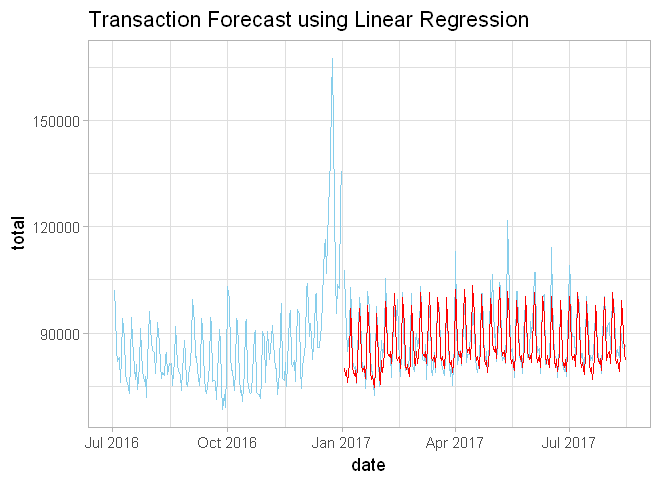

In [23]:
chart <- train %>%
  filter(date > '2016-07-01') %>%
  
  # training data
  ggplot(aes(x = date, y = total)) +
  geom_line( color = "sky blue") +
  
  # actual
  geom_line(aes(y = actuals), color = "sky blue", data = predictions) +
  
  # predictions
  geom_line(aes(y = predictions), color = "red", data = predictions) +


  labs(title = "Transaction Forecast using Linear Regression")
chart


### ARIMA forecast

Prepare data to filter out leap days, first day of the year, X'mas, where not all stores have data.  Fill in 6 rows of missing data
  

#### Reference:  Need to finish reading http://otexts.org/fpp2/lag-plots.html

In [24]:
x <- data.frame(date = seq(ymd('2013-01-01'),ymd('2017-08-15'), by = 'days'))

transData <- x %>%
  left_join(transactions, by = 'date') %>%
  select(date, transactions) %>%
  group_by(date) %>%
  summarize(total = sum(transactions)) %>%
  ungroup() %>%
  filter(!date %in% as.Date(c('2016-02-29', '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01',
                             '2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'))) %>% 
  fill(total) # fills in missing observations from the last non-missing value 
  
  
summary(transData)
subset(transData, is.na(transData$total))
subset(transData, total == min(transData$total))
subset(transData, total == max(transData$total))
#subset(transactions, date == '2016-01-04') # few stores have data,  no data on 2016/1/3
subset(transData, date == '2016-01-02')


      date                total       
 Min.   :2013-01-02   Min.   : 17829  
 1st Qu.:2014-02-27   1st Qu.: 76281  
 Median :2015-04-24   Median : 81645  
 Mean   :2015-04-24   Mean   : 84304  
 3rd Qu.:2016-06-19   3rd Qu.: 90783  
 Max.   :2017-08-15   Max.   :171169  

date,total


date,total
2016-01-04,17829


date,total
2015-12-24,171169


date,total
2016-01-02,69628


Update outliers with most recent value from 2016-01-02

In [25]:
transData$total[transData$date == "2016-01-04"] <- 69628
transData$total[transData$date == "2016-01-03"] <- 69628

In [26]:
summary(transData)

      date                total       
 Min.   :2013-01-02   Min.   : 63705  
 1st Qu.:2014-02-27   1st Qu.: 76281  
 Median :2015-04-24   Median : 81645  
 Mean   :2015-04-24   Mean   : 84335  
 3rd Qu.:2016-06-19   3rd Qu.: 90783  
 Max.   :2017-08-15   Max.   :171169  

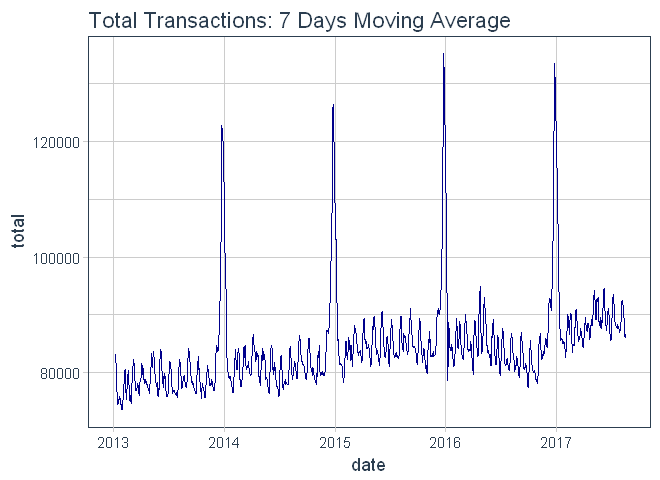

In [27]:
transData %>%
    ggplot(aes(date, total)) +
    #geom_line(col = palette_light()[1]) +
    #geom_point(col = palette_light()[1]) +
    geom_ma(ma_fun = SMA, n = 7, linetype = 'solid') +
    theme_tq() +
    scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
    labs(title = "Total Transactions: 7 Days Moving Average")

Turn observations into at ts object:  
http://otexts.org/fpp2/ts-objects.html

In [28]:
table(year(transData$date))
count(transData)


2013 2014 2015 2016 2017 
 363  363  363  363  226 

n
1678


In [29]:
transTS <- ts(transData$total,     
           start = c(2013, 1),
           frequency = 363)
str(transTS)
head(transTS,10)
tail(transTS,10)

 Time-Series [1:1678] from 2013 to 2018: 93215 78504 78494 93573 90464 ...


Time Series:
Start = c(2013, 1) 
End = c(2013, 10) 
Frequency = 363 
 [1] 93215 78504 78494 93573 90464 75597 72325 71971 66383 70338

Time Series:
Start = c(2017, 217) 
End = c(2017, 226) 
Frequency = 363 
 [1] 96162 87072 83422 85452 83064 89551 89927 85993 85448 86561

Try some plots in the forecast package

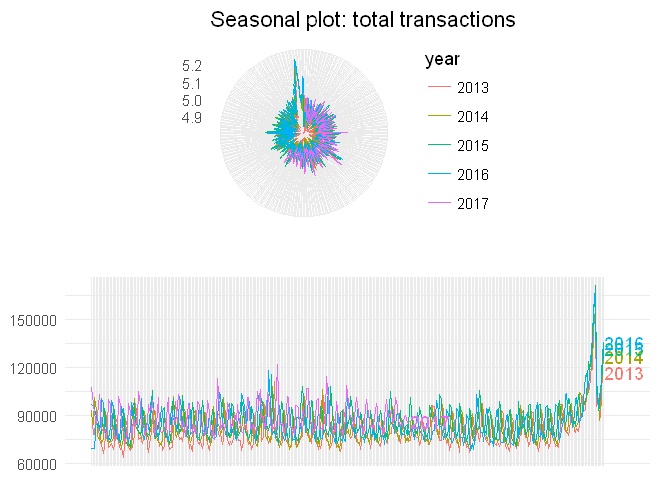

In [30]:
chart1 <- ggseasonplot(log10(transTS), polar=TRUE, season.labels = NULL, xlab = NULL,  ylab = "" ) +
ggtitle("Seasonal plot: total transactions")+
theme_minimal() +
theme(axis.title.x=element_blank(),
      axis.text.x=element_blank(),
      axis.ticks.x=element_blank())


chart2 <- ggseasonplot(transTS, year.labels=TRUE, year.labels.left=FALSE) +
          ggtitle("") +
          theme_minimal() +
          theme(axis.title.x=element_blank(),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank())

layout <- matrix(c(1,2),2,1,byrow=TRUE)
multiplot(chart1, chart2, layout=layout)

## TO DO:  http://otexts.org/fpp2/lag-plots.html

Split dataset into training and testing set

In [31]:
train <- window(transTS, start=c(2013,1), end = c(2016,363))
test <- window(transTS, start=c(2017,1), end=c(2017,226))
head(train,10)
tail(test,10)

Time Series:
Start = c(2013, 1) 
End = c(2013, 10) 
Frequency = 363 
 [1] 93215 78504 78494 93573 90464 75597 72325 71971 66383 70338

Time Series:
Start = c(2017, 217) 
End = c(2017, 226) 
Frequency = 363 
 [1] 96162 87072 83422 85452 83064 89551 89927 85993 85448 86561

#### Fit the ARIMA model

In [32]:
fit_arima <- auto.arima(train)
fit_arima

Series: train 
ARIMA(5,1,3) 

Coefficients:
         ar1      ar2     ar3      ar4      ar5      ma1     ma2      ma3
      0.1564  -0.9768  0.0521  -0.4349  -0.4041  -0.2753  0.6612  -0.4232
s.e.  0.0356   0.0251  0.0489   0.0241   0.0306   0.0342  0.0197   0.0345

sigma^2 estimated as 41947279:  log likelihood=-14790.88
AIC=29599.75   AICc=29599.88   BIC=29647.27

#### model coefficients

In [33]:
sw_tidy(fit_arima)

term,estimate
ar1,0.15638024
ar2,-0.97677582
ar3,0.05212243
ar4,-0.43487789
ar5,-0.40410588
ma1,-0.27532688
ma2,0.66123680
ma3,-0.42324651


#### model performance

In [34]:
sw_glance(fit_arima)

model.desc,sigma,logLik,AIC,BIC,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
"ARIMA(5,1,3)",6476.672,-14790.88,29599.75,29647.27,52.79744,6456.568,4207.366,-0.3384578,4.834486,0.5426333,-0.0263246


#### model residuals

In [35]:
head(sw_augment(fit_arima))

index,.actual,.fitted,.resid
2013.000,93215,93121.79,93.21489
2013.003,78504,88289.48,-9785.47975
2013.006,78494,77936.88,557.12084
2013.008,93573,87083.80,6489.20206
2013.011,90464,94070.82,-3606.82270
2013.014,75597,83874.82,-8277.82478


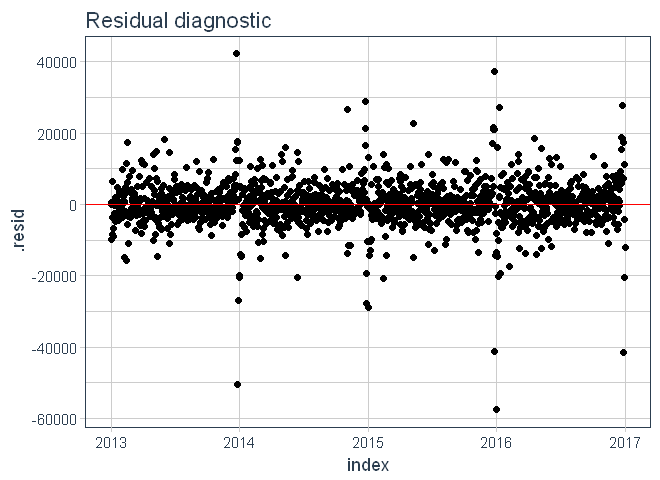

In [36]:
sw_augment(fit_arima) %>%
    ggplot(aes(x = index, y = .resid)) +
    geom_point() + 
    geom_hline(yintercept = 0, color = "red") + 
    labs(title = "Residual diagnostic") +
    theme_tq()

#### Forecast

In [37]:
fcast_arima <- forecast(fit_arima, h = 226)

In [38]:
head(fcast_arima)

$method
[1] "ARIMA(5,1,3)"

$model
Series: train 
ARIMA(5,1,3) 

Coefficients:
         ar1      ar2     ar3      ar4      ar5      ma1     ma2      ma3
      0.1564  -0.9768  0.0521  -0.4349  -0.4041  -0.2753  0.6612  -0.4232
s.e.  0.0356   0.0251  0.0489   0.0241   0.0306   0.0342  0.0197   0.0345

sigma^2 estimated as 41947279:  log likelihood=-14790.88
AIC=29599.75   AICc=29599.88   BIC=29647.27

$level
[1] 80 95

$mean
Time Series:
Start = c(2017, 1) 
End = c(2017, 226) 
Frequency = 363 
  [1] 132095.1 109661.2 104589.5 111992.0 115293.7 119474.5 128560.3 124899.9
  [9] 111243.4 110004.3 117318.5 116880.9 117021.8 123909.9 122146.7 112384.7
 [17] 113055.0 119550.8 117386.2 115695.6 121537.4 120893.8 113315.2 114673.2
 [25] 120397.3 117490.2 115071.0 120302.7 120294.2 114007.7 115532.4 120613.3
 [33] 117480.5 114844.4 119634.4 119969.3 114514.7 115996.6 120556.0 117455.8
 [41] 114831.5 119246.8 119757.3 114893.4 116258.3 120389.6 117442.8 114926.6
 [49] 118998.8 119591.6 115187.5 1

In [39]:
fcast_tbl <- sw_sweep(fcast_arima) %>%
  filter(key == "forecast") %>%
  as.data.frame() %>%
  mutate(date =  seq(ymd('2017-01-02'),ymd('2017-08-15'), by = 'days'))
tail(fcast_tbl)

actual_tbl <- transData %>%
  filter(date > '2017-01-01')
  
tail(actual_tbl)
  

,index,key,value,lo.80,lo.95,hi.80,hi.95,date
221,2017.606,forecast,117876.4,70741.33,45789.54,165011.4,189963.2,2017-08-10
222,2017.609,forecast,117595.0,70356.08,45349.29,164834.0,189840.8,2017-08-11
223,2017.612,forecast,117184.9,69848.93,44790.80,164520.8,189578.9,2017-08-12
224,2017.614,forecast,117638.9,70207.08,45098.17,165070.8,190179.7,2017-08-13
225,2017.617,forecast,117840.9,70306.39,45143.16,165375.3,190538.5,2017-08-14
226,2017.620,forecast,117309.2,69674.51,44458.24,164943.8,190160.1,2017-08-15


date,total
2017-08-10,83064
2017-08-11,89551
2017-08-12,89927
2017-08-13,85993
2017-08-14,85448
2017-08-15,86561


#### Very bad results.  Check how to run ARIMA model

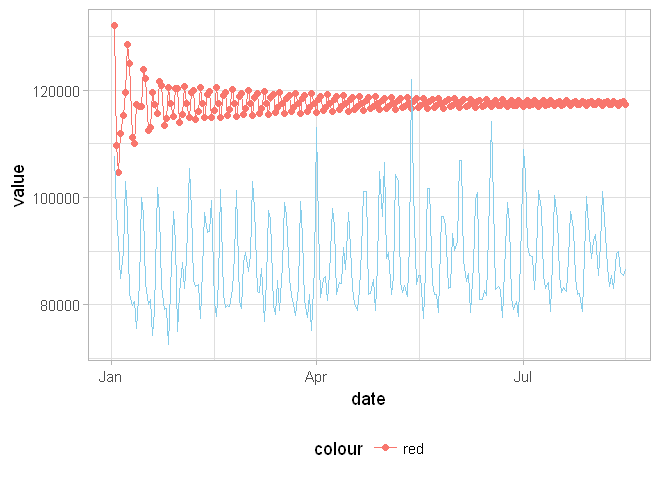

In [40]:
# Visualize the forecast with ggplot
fcast_tbl  %>%
    ggplot(aes(x = date, y = value, color = "red")) +
    #geom_ribbon(aes(ymin = lo.95, ymax = hi.95), 
    #            fill = "#D5DBFF", color = NA, size = 0) +
    geom_line() +
    geom_point() +
    geom_line(aes(x = date, y = total), data = actual_tbl, color = "sky blue")
    



### autocorrelation function or ACF. The plot is also known as a correlogram

When data are seasonal, the autocorrelations will be larger for the seasonal lags (at multiples of the seasonal frequency) than for other lags.

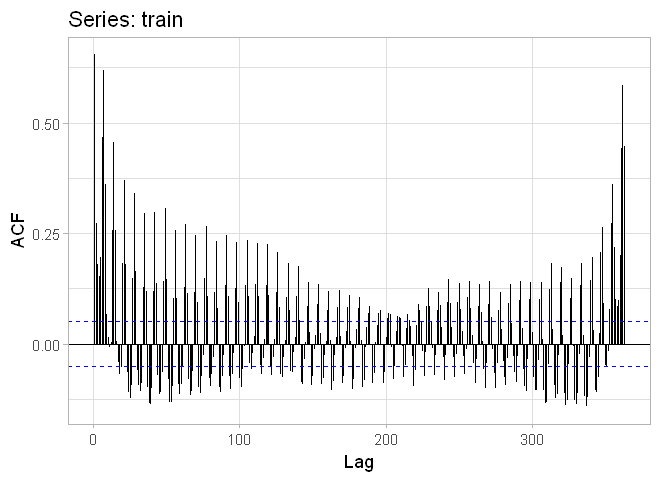

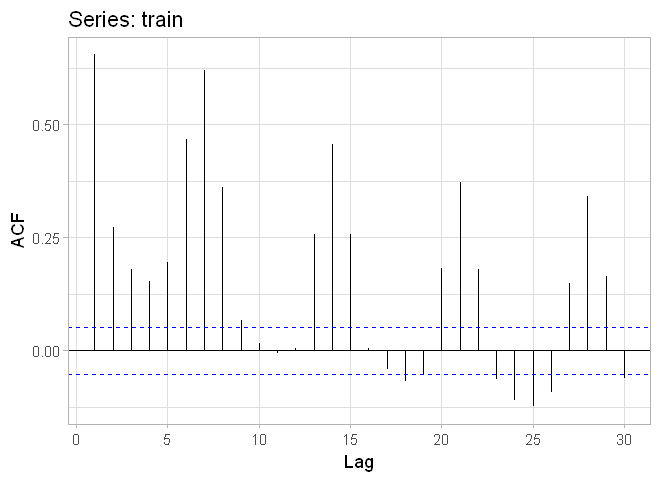

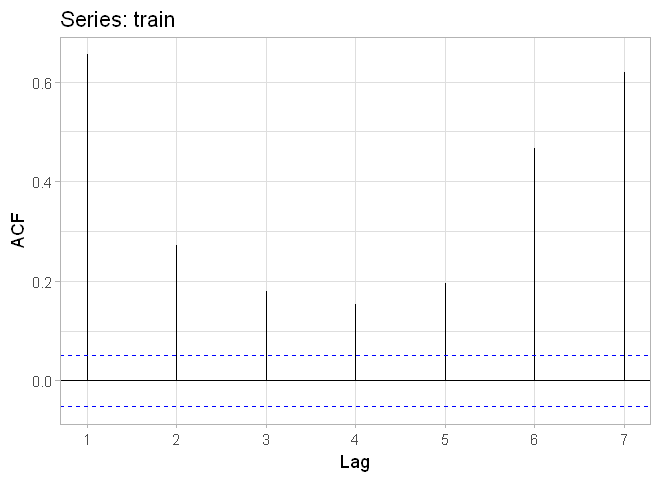

In [41]:
ggAcf(train, lag = 363)
ggAcf(train, lag = 30)
ggAcf(train, lag = 7)

## Prophet Package
https://research.fb.com/prophet-forecasting-at-scale/

In [42]:
library(prophet)

Prophet takes ds for time-series, and y for the predicted variable

###  Baseline Performance

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column must contain a date or datetime (either is fine). The y column must be numeric, and represents the measurement we wish to forecast.
 
Outliers should be removed. 

In [43]:
library(prophet)

In [44]:
transData <- transactions %>%
  select(date, transactions) %>%
  group_by(date) %>%
  summarize(total = sum(transactions)) %>%
  ungroup() %>%
  rename(y = total, ds = date) %>%
  filter(y > 50000)
head(transData)

ds,y
2013-01-02,93215
2013-01-03,78504
2013-01-04,78494
2013-01-05,93573
2013-01-06,90464
2013-01-07,75597


In [45]:
m <- prophet(transData)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


Initial log joint probability = -7.11134
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


This cross validation procedure can be done automatically for a range of historical cutoffs using the cross_validation function. We specify the forecast horizon (horizon), and then optionally the size of the initial training period (initial) and the spacing between cutoff dates (period). By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

In [46]:
df.cv <- cross_validation(m, horizon = 227, units = 'days', period = 227, initial = 1440);

Initial log joint probability = -30.6758
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Warning message:
"Unknown or uninitialised column: 'y'."

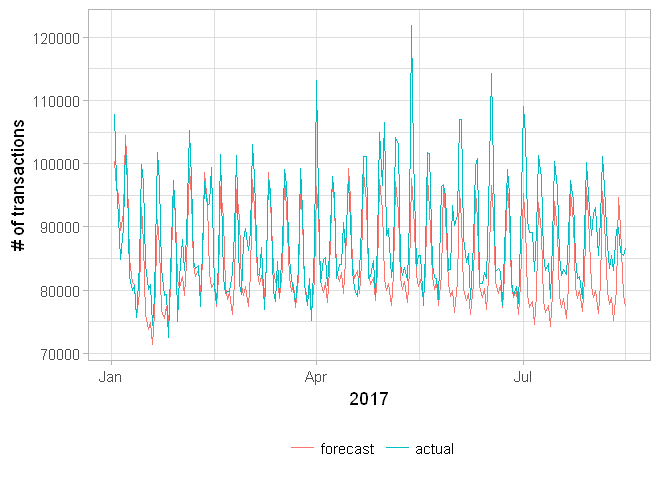

In [47]:
ggplot() + 
  # forecast
  geom_line(data = df.cv, aes(x = ds, y = yhat, color = "red")) +
  
  geom_line(data = df.cv, aes(x = ds, y = y, color = "sky blue")) +
  xlab('2017') +
  ylab('# of transactions') +
  scale_color_discrete(name = "", labels = c("forecast", "actual"))
  

RMSE for 2017

In [48]:
rmse = sqrt(mean(df.cv$y - df.cv$yhat)^2)
print(rmse)

[1] 4155.578


In [49]:
future <- make_future_dataframe(m, periods = 227)
forecast <- predict(m, future)

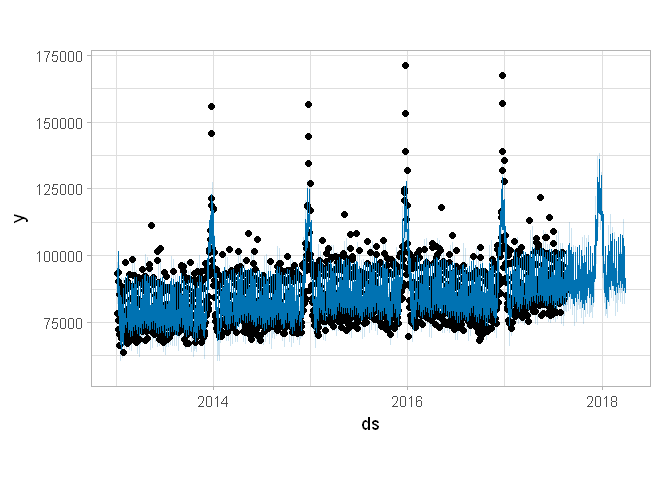

In [50]:
plot(m, forecast)

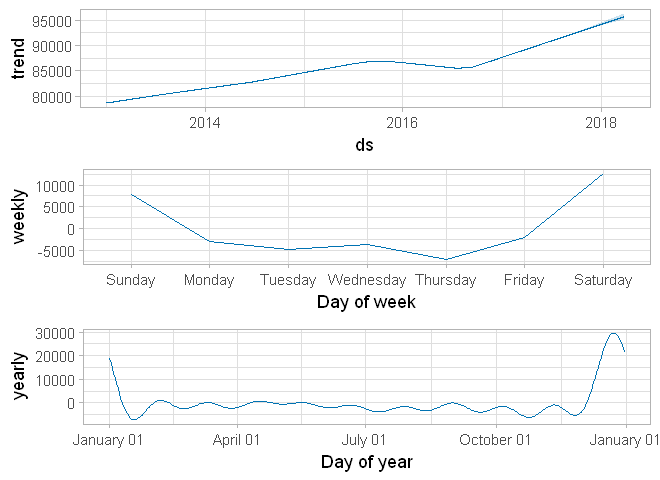

In [51]:
prophet_plot_components(m, forecast)

### Add Holidays

Load holidays for customization.   Filter to keep National holidays only.  Keep first instance of a date if multiple rows of the same date are present.

The holidays dataframe should have two columns (holiday and ds) and a row for each occurrence of the holiday. It must include all occurrences of the holiday, both in the past (back as far as the historical data go) and in the future (out as far as the forecast is being made).

In [52]:
holidays <- readRDS('holidays.rds')
holidays <- holidays %>%
  filter(locale == "National" ) %>%
  distinct(date, .keep_all = TRUE) %>%
  select(description, date) %>%
  rename(holiday = description, ds = date)
  
head(holidays)

holiday,ds
Primer Grito de Independencia,2012-08-10
Independencia de Guayaquil,2012-10-09
Traslado Independencia de Guayaquil,2012-10-12
Dia de Difuntos,2012-11-02
Independencia de Cuenca,2012-11-03
Navidad-4,2012-12-21


In [53]:
m <- prophet(transData, holidays = holidays)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


Initial log joint probability = -7.11134
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [54]:
df.cv <- cross_validation(m, horizon = 227, units = 'days', period = 227, initial = 1440);

Initial log joint probability = -30.6758
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Warning message:
"Unknown or uninitialised column: 'y'."

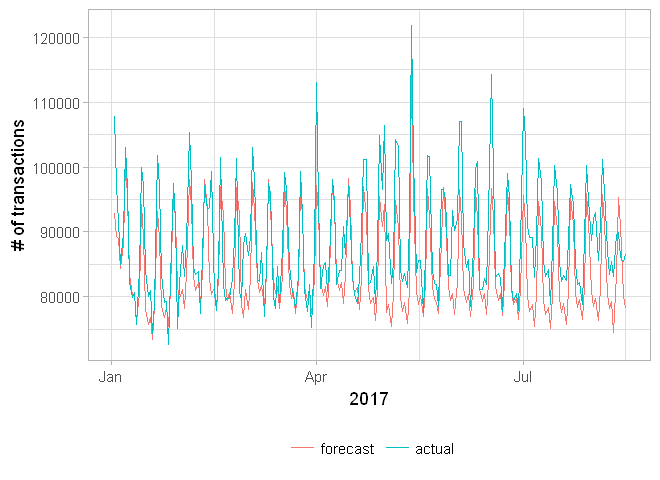

In [55]:
ggplot() + 
  # forecast
  geom_line(data = df.cv, aes(x = ds, y = yhat, color = "red")) +
  
  # actual
  geom_line(data = df.cv, aes(x = ds, y = y, color = "sky blue")) +
  xlab('2017') +
  ylab('# of transactions') +
  scale_color_discrete(name = "", labels = c("forecast", "actual"))
  

In [56]:
rmse = sqrt(mean(df.cv$y - df.cv$yhat)^2)
print(rmse)

[1] 4179.931


In [57]:
future <- make_future_dataframe(m, periods = 227)
forecast <- predict(m, future)

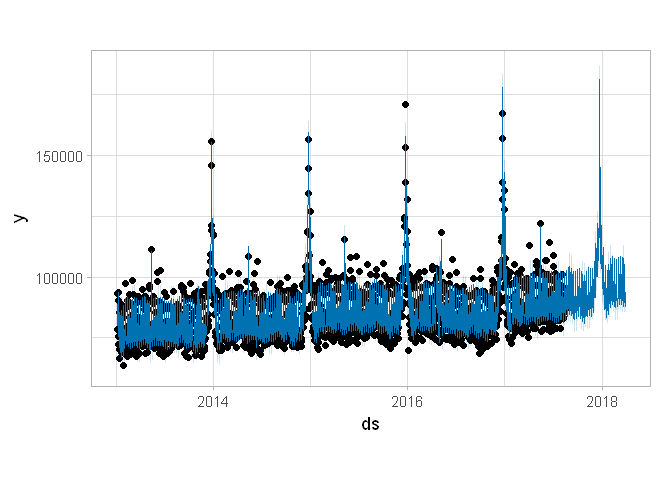

In [58]:
plot(m, forecast)

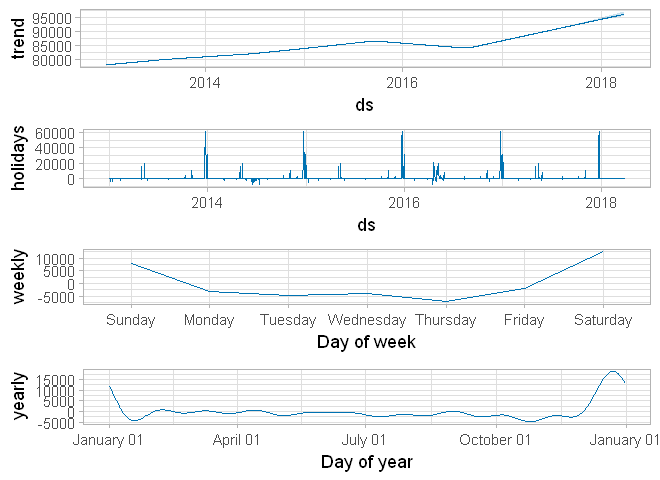

In [59]:
prophet_plot_components(m, forecast)

### Add monthly seasonality

prophet(df = NULL, growth = "linear", changepoints = NULL,
n.changepoints = 25, yearly.seasonality = "auto",
weekly.seasonality = "auto", daily.seasonality = "auto",
holidays = NULL, seasonality.prior.scale = 10,
holidays.prior.scale = 10, changepoint.prior.scale = 0.05,
mcmc.samples = 0, interval.width = 0.8, uncertainty.samples = 1000,
fit = TRUE, ...)

In [60]:
m <- prophet(transData, 
             holidays = holidays, 
             weekly.seasonality = TRUE, 
             yearly.seasonality = TRUE, 
             daily.seasonality = FALSE, 
             fit = FALSE)

In [61]:
m <- add_seasonality(m, name='monthly', period=30.5, fourier.order=5)

In [62]:
m <- fit.prophet(m, transData)

Initial log joint probability = -7.11134
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [63]:
df.cv <- cross_validation(m, horizon = 227, units = 'days', period = 227, initial = 1440);

Initial log joint probability = -30.6758
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Warning message:
"Unknown or uninitialised column: 'y'."

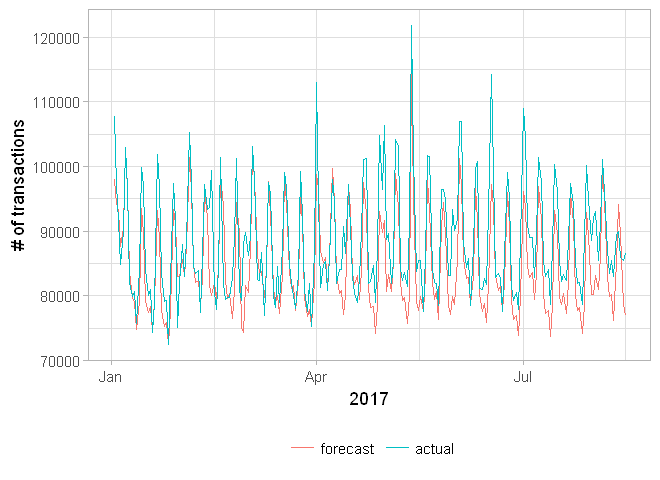

In [64]:
ggplot() + 
  # forecast
  geom_line(data = df.cv, aes(x = ds, y = yhat, color = "red")) +
  
  # actual
  geom_line(data = df.cv, aes(x = ds, y = y, color = "sky blue")) +
  xlab('2017') +
  ylab('# of transactions') +
  scale_color_discrete(name = "", labels = c("forecast", "actual"))

In [65]:
rmse = sqrt(mean(df.cv$y - df.cv$yhat)^2)
print(rmse)

[1] 3586.433


In [66]:
future <- make_future_dataframe(m, periods = 227)
forecast <- predict(m, future)

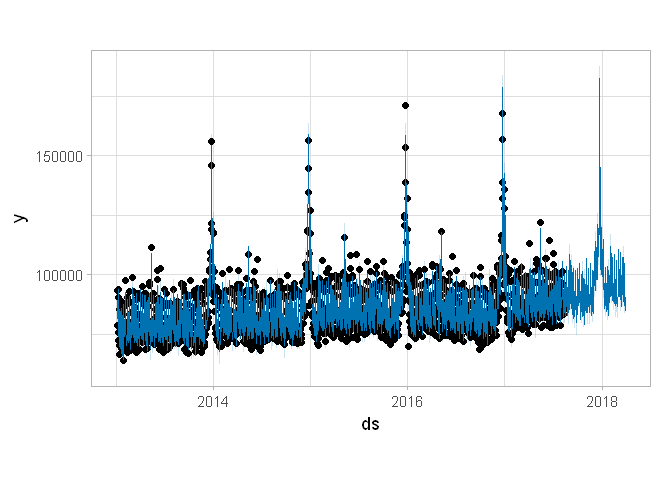

In [67]:
plot(m, forecast)

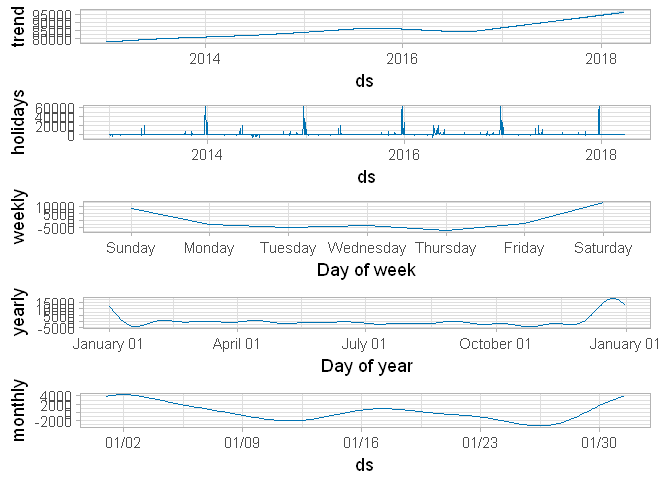

In [68]:
prophet_plot_components(m, forecast)

### Add paydays

In [69]:
# payday flag add 15th and last day of month 
lastDay <- seq(as.Date("2013-01-01"), length=62, by="1 month") - 1
midMonth <- seq(as.Date("2013-01-01"), length=62, by="1 month") + 14

In [70]:
x <- data_frame(
 holiday = "payday",
 ds = lastDay)
y <- data_frame(
 holiday = "payday",
 ds = midMonth)

payDays <- rbind(x, y)
holidays <- rbind(holidays, payDays)

In [71]:
m <- prophet(transData, 
             holidays = holidays, 
             weekly.seasonality = TRUE, 
             yearly.seasonality = TRUE, 
             daily.seasonality = FALSE, 
             fit = FALSE)

In [72]:
m <- add_seasonality(m, name='monthly', period=30.5, fourier.order=5)

In [73]:
m <- fit.prophet(m, transData)

Initial log joint probability = -7.11134
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [74]:
df.cv <- cross_validation(m, horizon = 227, units = 'days', period = 227, initial = 1440);

Initial log joint probability = -30.6758
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Warning message:
"Unknown or uninitialised column: 'y'."

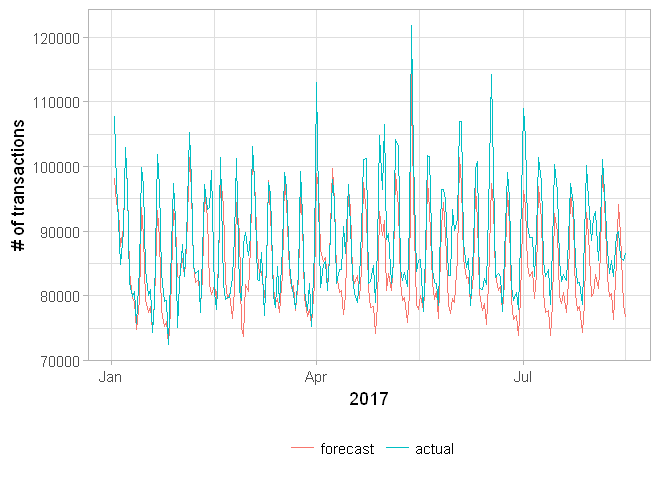

In [75]:
ggplot() + 
  # forecast
  geom_line(data = df.cv, aes(x = ds, y = yhat, color = "red")) +
  
  # actual
  geom_line(data = df.cv, aes(x = ds, y = y, color = "sky blue")) +
  xlab('2017') +
  ylab('# of transactions') +
  scale_color_discrete(name = "", labels = c("forecast", "actual"))

In [76]:
rmse = sqrt(mean(df.cv$y - df.cv$yhat)^2)
print(rmse)

[1] 3563.854


In [77]:
future <- make_future_dataframe(m, periods = 227)
forecast <- predict(m, future)

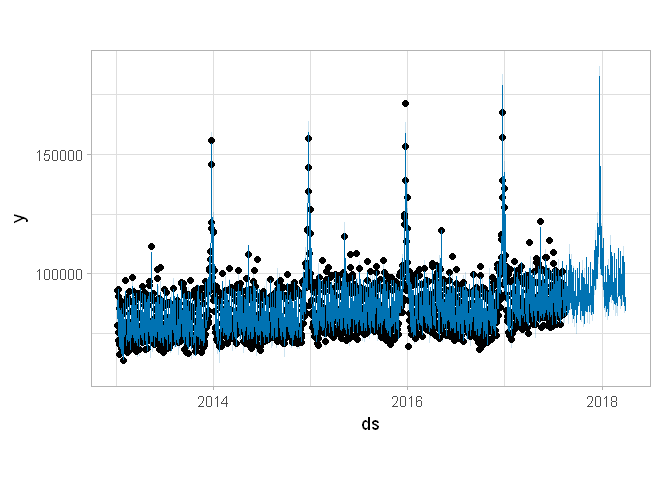

In [78]:
plot(m, forecast)

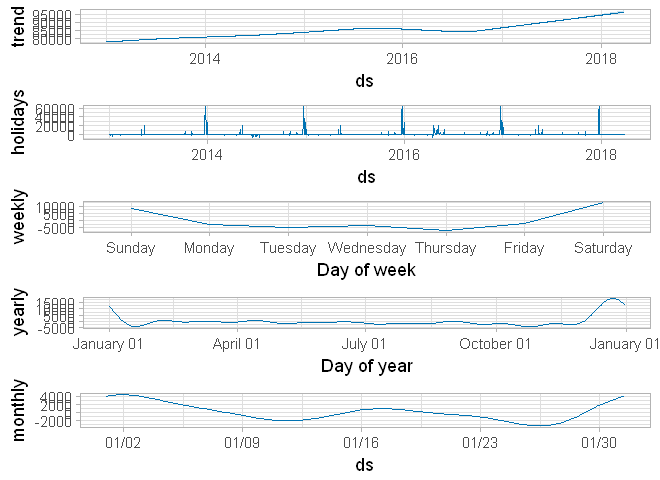

In [79]:
prophet_plot_components(m, forecast)

### Format Holidays table with lower_window and upper_window 

In [80]:
holidays$lower_window <- 0
holidays$upper_window <- 0

In [81]:
holidays$lower_window[holidays$holiday == 'Dia de la Madre'] <- -1

In [82]:
holidays <- holidays[!grepl('Dia de la Madre-1',holidays$holiday),]

In [83]:
holidays[grep("futbol", holidays$holiday), ]$holiday <- 'Mundial de futbol Brasil'

In [84]:
holidays$lower_window[holidays$holiday == 'Navidad'] <- -4

In [85]:
holidays$upper_window[grepl('Navidad-',holidays$holiday)] <- +1

In [86]:
holidays <- holidays[!grepl('Navidad-',holidays$holiday),]
holidays <- holidays[!grepl('Navidad\\+',holidays$holiday),]

In [87]:
holidays$upper_window[holidays$holiday == 'Terremoto Manabi'] <- 30

In [88]:
holidays <- holidays[!grepl('Terremoto Manabi\\+',holidays$holiday),]

In [89]:
holidays$lower_window[holidays$holiday == 'Primer dia del ano'] <- -1

In [90]:
holidays <- holidays[!grepl('Primer dia del ano-1',holidays$holiday),]

Re-run model with new Holidays table

In [91]:
m <- prophet(transData, 
             holidays = holidays, 
             weekly.seasonality = TRUE, 
             yearly.seasonality = TRUE, 
             daily.seasonality = FALSE, 
             fit = FALSE)

In [92]:
m <- add_seasonality(m, name='monthly', period=30.5, fourier.order=5)

In [93]:
m <- fit.prophet(m, transData)

Initial log joint probability = -7.11134
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [94]:
df.cv <- cross_validation(m, horizon = 227, units = 'days', period = 227, initial = 1440);

Initial log joint probability = -30.6758
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Warning message:
"Unknown or uninitialised column: 'y'."

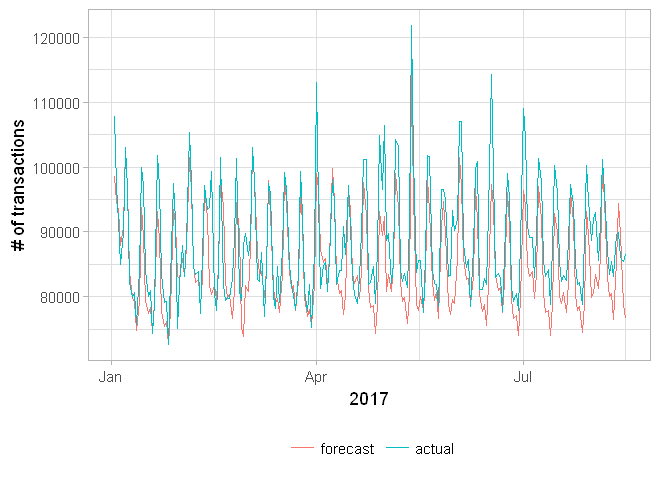

In [95]:
ggplot() + 
  # forecast
  geom_line(data = df.cv, aes(x = ds, y = yhat, color = "red")) +
  
  # actual
  geom_line(data = df.cv, aes(x = ds, y = y, color = "sky blue")) +
  xlab('2017') +
  ylab('# of transactions') +
  scale_color_discrete(name = "", labels = c("forecast", "actual"))

In [96]:
rmse = sqrt(mean(df.cv$y - df.cv$yhat)^2)
print(rmse)

[1] 3495.692


In [97]:
future <- make_future_dataframe(m, periods = 227)
forecast <- predict(m, future)

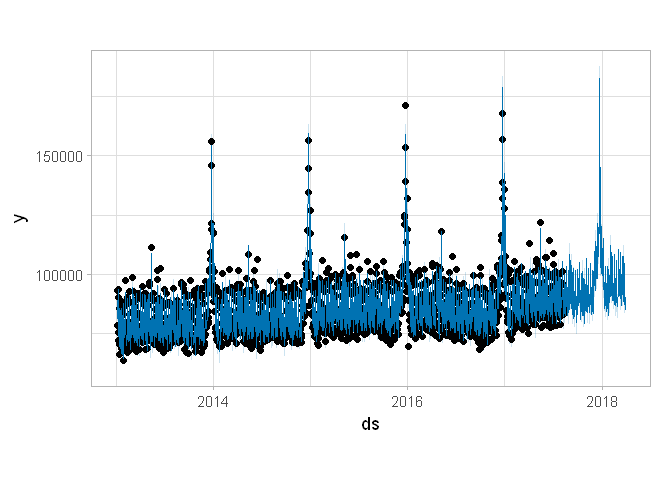

In [98]:
plot(m, forecast)

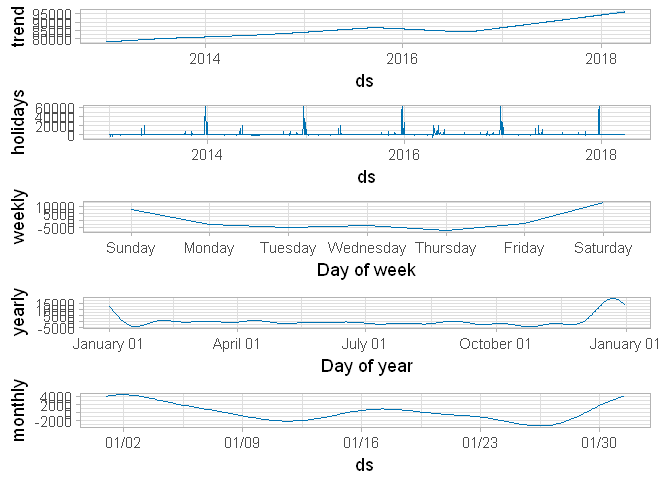

In [99]:
prophet_plot_components(m, forecast)

### Add uncertainty intervals

In [100]:
m <- prophet(transData, 
             holidays = holidays, 
             weekly.seasonality = TRUE, 
             yearly.seasonality = TRUE, 
             daily.seasonality = FALSE, 
             fit = FALSE,
             mcmc_samples=300)
m <- add_seasonality(m, name='monthly', period=30.5, fourier.order=5)
m <- fit.prophet(m, transData)
df.cv <- cross_validation(m, horizon = 227, units = 'days', period = 227, initial = 1440)

Initial log joint probability = -7.11134
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -30.6758
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Warning message:
"Unknown or uninitialised column: 'y'."

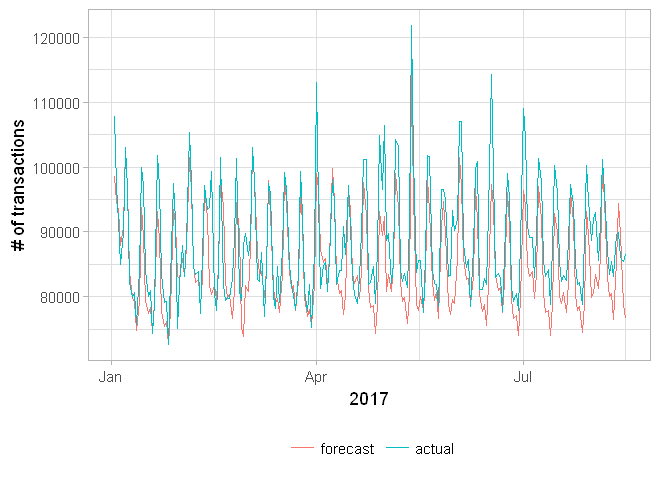

In [101]:
ggplot() + 
  # forecast
  geom_line(data = df.cv, aes(x = ds, y = yhat, color = "red")) +
  
  # actual
  geom_line(data = df.cv, aes(x = ds, y = y, color = "sky blue")) +
  xlab('2017') +
  ylab('# of transactions') +
  scale_color_discrete(name = "", labels = c("forecast", "actual"))

In [102]:
rmse = sqrt(mean(df.cv$y - df.cv$yhat)^2)
print(rmse)

[1] 3495.692


In [103]:
future <- make_future_dataframe(m, periods = 227)
forecast <- predict(m, future)

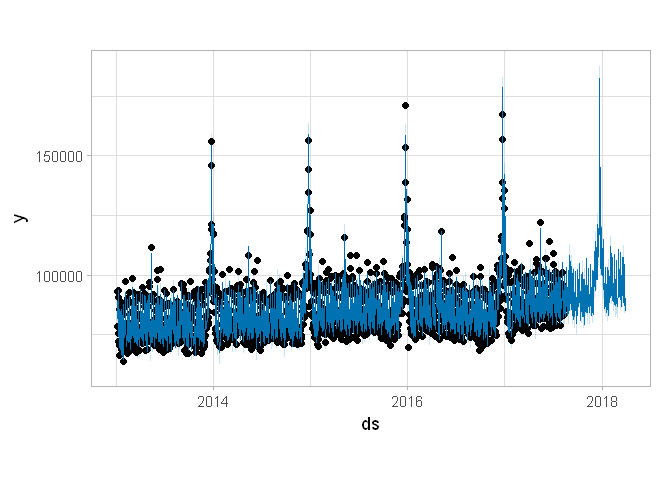

In [104]:
plot(m, forecast)

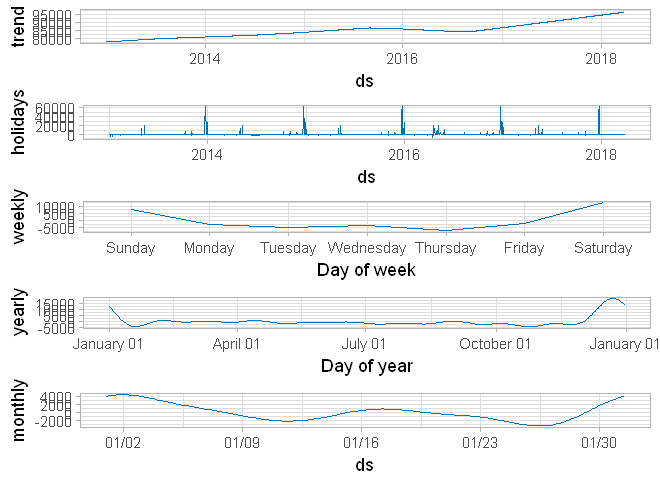

In [105]:
prophet_plot_components(m, forecast)

### Adjusting trend flexibility
If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument changepoint_prior_scale. By default, this parameter is set to 0.05. Increasing it will make the trend more flexible

In [106]:
m <- prophet(transData, 
             holidays = holidays, 
             weekly.seasonality = TRUE, 
             yearly.seasonality = TRUE, 
             daily.seasonality = FALSE, 
             fit = FALSE,
             mcmc_samples=300,
             changepoint.prior.scale = 0.2)  # Increase to make the trend more flexible
m <- add_seasonality(m, name='monthly', period=30.5, fourier.order=5)
m <- fit.prophet(m, transData)
df.cv <- cross_validation(m, horizon = 227, units = 'days', period = 227, initial = 1440)

Initial log joint probability = -7.11134
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -30.6758
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Warning message:
"Unknown or uninitialised column: 'y'."

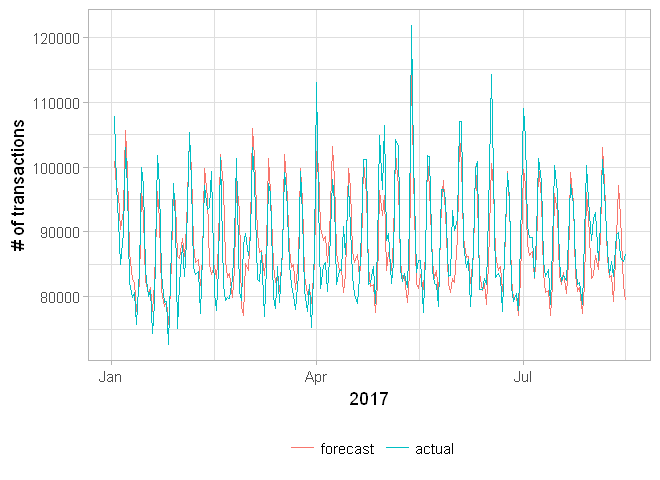

In [107]:
ggplot() + 
  # forecast
  geom_line(data = df.cv, aes(x = ds, y = yhat, color = "red")) +
  
  # actual
  geom_line(data = df.cv, aes(x = ds, y = y, color = "sky blue")) +
  xlab('2017') +
  ylab('# of transactions') +
  scale_color_discrete(name = "", labels = c("forecast", "actual"))

In [108]:
rmse = sqrt(mean(df.cv$y - df.cv$yhat)^2)
print(rmse)

[1] 323.4435


In [109]:
future <- make_future_dataframe(m, periods = 227)
forecast <- predict(m, future)

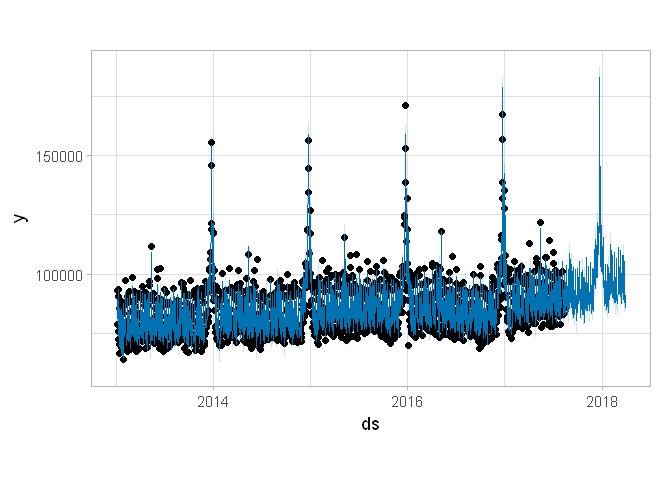

In [110]:
plot(m, forecast)

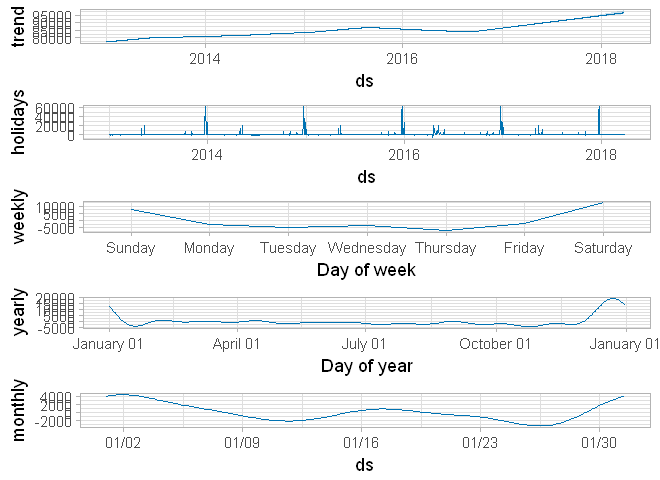

In [111]:
prophet_plot_components(m, forecast)

### Verify results again

In [112]:
train <- filter(transData, ds < '2017-01-01')
test <- filter(transData, ds >= '2017-01-01')

In [113]:
m <- prophet(train, 
             holidays = holidays, 
             weekly.seasonality = TRUE, 
             yearly.seasonality = TRUE, 
             daily.seasonality = FALSE, 
             fit = FALSE,
             mcmc_samples=300,
             changepoint.prior.scale = 0.2)  # Increase to make the trend more flexible
m <- add_seasonality(m, name='monthly', period=30.5, fourier.order=5)
m <- fit.prophet(m, train)

Initial log joint probability = -30.6758
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [114]:
future <- make_future_dataframe(m, periods = 365)
forecast <- predict(m, future)

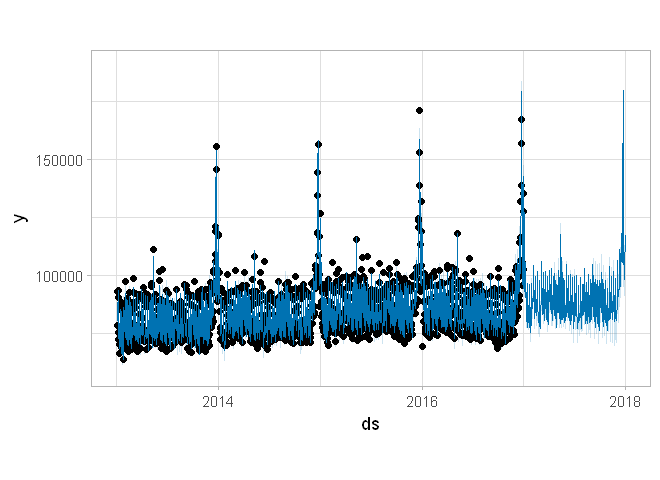

In [115]:
plot(m, forecast)

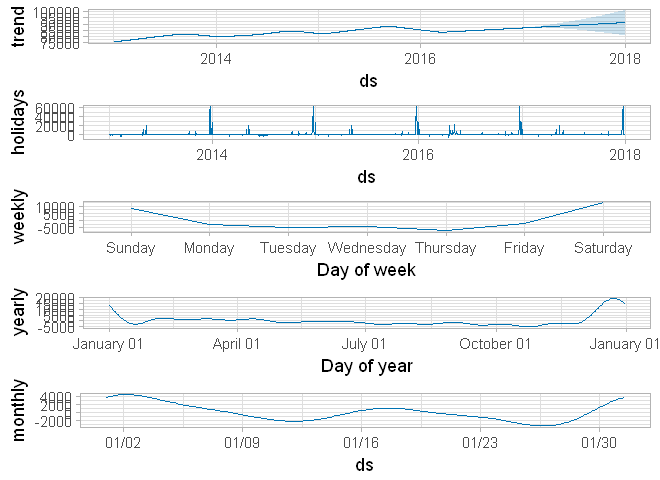

In [116]:
prophet_plot_components(m, forecast)

In [117]:
head(forecast)

ds,trend,Batalla de Pichincha,Batalla de Pichincha_lower,Batalla de Pichincha_upper,Black Friday,Black Friday_lower,Black Friday_upper,Carnaval,Carnaval_lower,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat_lower,yhat_upper,trend_lower,trend_upper,yhat
2013-01-02,75626.89,0,0,0,0,0,0,0,0,...,-3770.049,-3770.049,11986.407,11986.407,11986.407,81279.41,90990.38,75626.89,75626.89,86266.15
2013-01-03,75654.42,0,0,0,0,0,0,0,0,...,-7033.074,-7033.074,10690.098,10690.098,10690.098,75880.31,85507.96,75654.42,75654.42,80876.92
2013-01-04,75681.96,0,0,0,0,0,0,0,0,...,-2048.507,-2048.507,9365.612,9365.612,9365.612,78728.11,88506.95,75681.96,75681.96,83850.68
2013-01-05,75709.49,0,0,0,0,0,0,0,0,...,12377.449,12377.449,8033.019,8033.019,8033.019,88575.87,98338.24,75709.49,75709.49,93562.94
2013-01-06,75737.02,0,0,0,0,0,0,0,0,...,8050.679,8050.679,6712.052,6712.052,6712.052,84695.47,94756.38,75737.02,75737.02,89900.95
2013-01-07,75764.56,0,0,0,0,0,0,0,0,...,-2683.334,-2683.334,5421.720,5421.720,5421.720,72203.49,81652.72,75764.56,75764.56,77125.00


In [118]:
chartData <- forecast %>% 
  select(ds, yhat) %>%
  filter(ds >= "2017-01-01" & ds <= '2017-08-15') 
chartData$ds <- as.Date(chartData$ds)

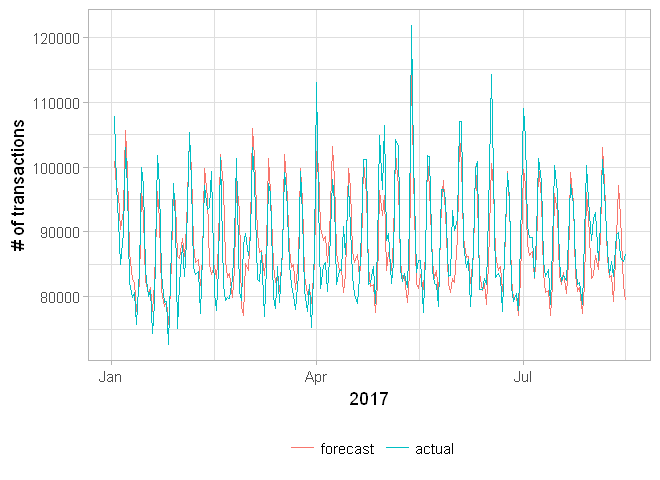

In [119]:
ggplot() + 
  # forecast
  geom_line(data = chartData, aes(x = ds, y = yhat, color = "red")) +
  
  # actual
  geom_line(data = test, aes(x = ds, y = y, color = "sky blue")) +
  xlab('2017') +
  ylab('# of transactions') +
  scale_color_discrete(name = "", labels = c("forecast", "actual"))

In [120]:
rmse = sqrt(mean(test$y - chartData$yhat)^2)
print(rmse)

[1] 323.4435


### Changepoint.prior.scale set to 0.1 instead of 0.2 (less flexible)

In [121]:
m <- prophet(train, 
             holidays = holidays, 
             weekly.seasonality = TRUE, 
             yearly.seasonality = TRUE, 
             daily.seasonality = FALSE, 
             fit = FALSE,
             mcmc_samples=300,
             changepoint.prior.scale = 0.1)  # Increase to make the trend more flexible
m <- add_seasonality(m, name='monthly', period=30.5, fourier.order=5)
m <- fit.prophet(m, train)

Initial log joint probability = -30.6758
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [122]:
future <- make_future_dataframe(m, periods = 365)
forecast <- predict(m, future)

chartData <- forecast %>% 
  select(ds, yhat) %>%
  filter(ds >= "2017-01-01" & ds <= '2017-08-15') 
chartData$ds <- as.Date(chartData$ds)

In [123]:
rmse = sqrt(mean(test$y - chartData$yhat)^2)
print(rmse)

[1] 2666.659


### Changepoint.prior.scale set to 0.3 instead of 0.2 (more flexible)

In [124]:
m <- prophet(train, 
             holidays = holidays, 
             weekly.seasonality = TRUE, 
             yearly.seasonality = TRUE, 
             daily.seasonality = FALSE, 
             fit = FALSE,
             mcmc_samples=300,
             changepoint.prior.scale = 0.3)  # Increase to make the trend more flexible
m <- add_seasonality(m, name='monthly', period=30.5, fourier.order=5)
m <- fit.prophet(m, train)

Initial log joint probability = -30.6758
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [125]:
future <- make_future_dataframe(m, periods = 365)
forecast <- predict(m, future)

chartData <- forecast %>% 
  select(ds, yhat) %>%
  filter(ds >= "2017-01-01" & ds <= '2017-08-15') 
chartData$ds <- as.Date(chartData$ds)

In [126]:
rmse = sqrt(mean(test$y - chartData$yhat)^2)
print(rmse)

[1] 884.5174
